In [1]:
%matplotlib inline
from utils import read, createGraph, genders, functionals
import networkx as nx
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
th = 2
data_dir = "./data/by_movie/*"
info_dir = "./data/speakersWithCharacterInfo/"

## Read all scripts

In [3]:
data = {}
for script in glob(data_dir):
    try:
        char_list, adj = read(script, threshold = th)
        
        gender_file = info_dir + basename(script).replace(".", "_") + ".txt"
        if exists(gender_file):
            gens = genders(gender_file)
        else:
            gens = defaultdict(lambda: 'unknown')
        
        G = createGraph(char_list, adj, gens)
           
        data[basename(script)] = G
    except:
        pass

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen. Lets check our numbers.

In [4]:
total, males, females = 0, 0, 0
for _, G in data.items():
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 14592
males: 0.37%
females: 0.16%


What if we drop unknown?... shouldn't matter right?

In [5]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.70%
females: 0.30%


# Graph analysis

### Degree centrality

#### Average degree

In [6]:
male_deg, female_deg = [], []
for script, G in data.items():
    degrees = nx.degree(G)
    
    male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/home/victor/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


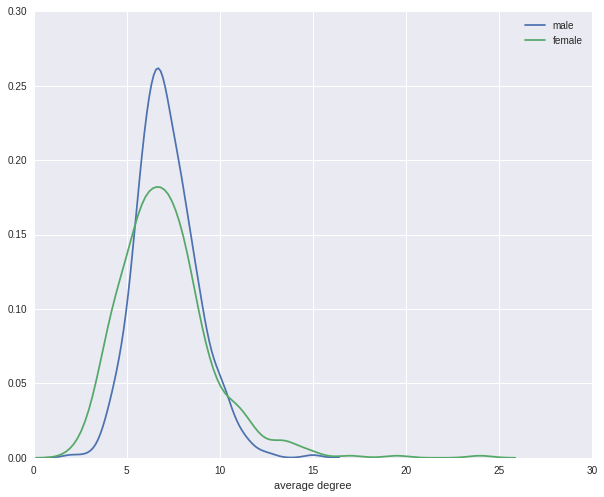

In [7]:
sns.distplot(male_deg, hist = False, label = "male");
sns.distplot(female_deg, hist = False, label = "female");
plt.legend();
plt.xlabel("average degree");

There is no real difference in the number of connections between men and women.

In [8]:
#Remove nans
male_deg, female_deg = np.array(male_deg), np.array(female_deg)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]


sp.stats.ttest_ind(male_deg, female_deg)

Ttest_indResult(statistic=0.50617752765310209, pvalue=0.61285476539479333)

### Betweeness Centrality

#### Average centrality

In [9]:
male_cent, female_cent = [], []
for script, G in data.items():
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/home/victor/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

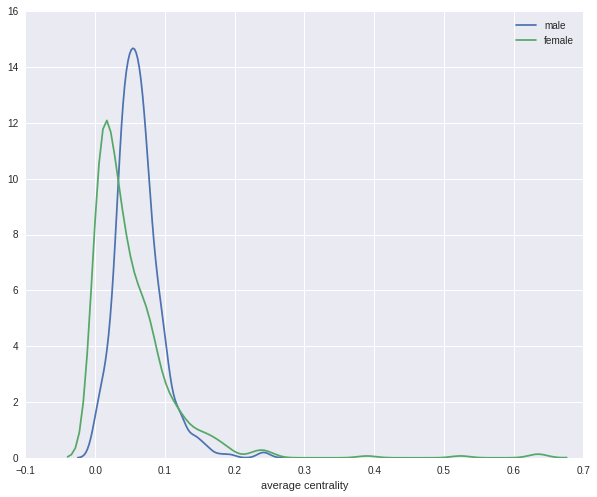

In [10]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 2.7951,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [11]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]


sp.stats.ttest_ind(male_cent, female_cent)

Ttest_indResult(statistic=2.7951335187934907, pvalue=0.0052970912912426648)

### Who are the most central women?

In [12]:
female_cent = []
for script, G in data.items():
    cents = nx.betweenness_centrality(G)

    for femme in G.nodes():
        if G.node[femme]['gender'] == 'female':
            female_cent.append((script, femme, cents[femme]))

Top 15 movies with the most central female lead. We got Sarah Connor and Erin Bronckovich!

In [13]:
sorted(female_cent, key = lambda x: x[2], reverse = True)[:15]

[('music_of_the_heart.xml', 32, 0.7738795186163606),
 ('8mm.xml', 20, 0.7719298245614036),
 ('frances.xml', 20, 0.7688689217758985),
 ('erin_brockovich.xml', 7, 0.7620772946859903),
 ('agnes_of_god.xml', 8, 0.75),
 ('high_fidelity.xml', 14, 0.7241666666666666),
 ('precious.xml', 15, 0.7236842105263157),
 ('bridesmaids.xml', 0, 0.7126626626626626),
 ('what_lies_beneath.xml', 1, 0.7014652014652014),
 ('terminator.xml', 11, 0.6764705882352943),
 ('legally_blonde.xml', 10, 0.6383465335169881),
 ('charade.xml', 16, 0.6362922705314009),
 ('wind_chill.xml', 0, 0.6333333333333333),
 ('drag_me_to_hell.xml', 9, 0.6317460317460317),
 ('juno.xml', 4, 0.6182539682539684)]

# Triads and love triangles
Can we say that love triangles are really that common?

In [14]:
# THIS IS OVERSTIMATING!

triads = []

for script, G in data.items():
    for i in G.nodes():
        for j in G.neighbors(i):
            for k in G.neighbors(i):
                if j == k:
                    continue

                triads.append(tuple(sorted([G.node[i]['gender'], G.node[j]['gender'], G.node[k]['gender']])))

The most common triads are FMM and MMM. Three females speaking to each other is the least common pattern.

In [15]:
T = sum(Counter(triads).values())

{k:v/T for k, v in Counter(triads).items()}

{('female', 'female', 'female'): 0.017559983846485914,
 ('female', 'female', 'male'): 0.07396081380289928,
 ('female', 'female', 'unknown'): 0.024453078219214327,
 ('female', 'male', 'male'): 0.15638829705755386,
 ('female', 'male', 'unknown'): 0.09258470150812549,
 ('female', 'unknown', 'unknown'): 0.02081018228405119,
 ('male', 'male', 'male'): 0.15878904346130815,
 ('male', 'male', 'unknown'): 0.14229296347356254,
 ('male', 'unknown', 'unknown'): 0.06484521869908509,
 ('unknown', 'unknown', 'unknown'): 0.24831571764771415}